
---
# Unit03: Processing passive seismic data I

This notebook has some practical processing activities of the Course **ProSeisSN**. It deals with time series processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

#### Dependencies: Obspy, Numpy, Matplotlib

#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***

In [ ]:
#------ Import OS Libraries
import sys
import os

#------ Work with the directory structure to include auxiliary codes
print('\n Local directory ==> ', os.getcwd())
print('  - Contents: ', os.listdir(), '\n')

path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path+"/CodePy")

%run ../CodePy/ImpMod.ipynb

#------ Alter default matplotlib rcParams
from matplotlib import rcParams
# Change the defaults of the runtime configuration settings in the global variable matplotlib.rcParams
plt.rcParams['figure.figsize'] = 9, 5
#plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams["figure.subplot.hspace"] = (.9)

---
## Accessing data

We work with data form an event occured in Acre in 2024,

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

As recorded at station IU HKT, distant $44^{\circ}$ from the event. We have two options:

- **Read** the data locally $\Longrightarrow$ skip next code, or

- **Retrive** the data from client **IRIS** $\Longrightarrow$ run next code skipping the next one.

---
#### The $\Downarrow$ first $\Downarrow$ line skips the following cell

In [ ]:
%%script echo skipping
"""
=========== RETRIEVE THE DATA FROM IRIS ===========
"""
#--------  Specify event's start and end times
starttime = UTCDateTime("2024-01-20T21:37:19.019539Z") - 60
endtime = UTCDateTime("2024-01-20T21:58:18.994539Z")
print(starttime, endtime)

# Use wildcards to select all three HH* channels
net = "IU"
sta = "HKT"
loc = "00"
chan = "HH*"

# Specify client. Opt:from obspy.clients.earthworm import Client
# Get waveforms with instrument response into a stream
# List of ObsPy clients: clients = ["IRIS", "NCEDC", "USGS", "GEONET", "RESIF", "INGV", "BGR", "ODC", "SCEDC"]
try:
  client = Client("IRIS")
  st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
except FDSNException:
  print(f"Chosen client is not working.")
  from obspy.clients.earthworm import Client
  client = Client("ETH")
  st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

#--------  Remove the instrument response in all the 3 components/traces.
st.remove_response(output = 'VEL')

#-------- Save the corrected data (wb=western-brazil, lp=low pass filtered)
filename = '../Data/wb11793085r' + '.mseed'
st[-1].write(filename, format='MSEED')

# Sanity
try:
    dummy = read(filename)
    print(f"Filtered Z-data at station IU HKT:\n {dummy[-1].stats}")
except:
    print(f".")
    print(f"Failed to write the data if file {filename}")

#--------  Start a list to record the processing flux in Unit03

Pflux = ['Unit03', 'written '+filename]
Pflux.append('remove_response')

---
#### The $\Downarrow$ first $\Downarrow$ line skips the following cell

In [ ]:
#%%script echo skipping
"""
=========== READ THE DATA LOCALLY ===========
"""
# Read the data into a stream object
filename = '../Data/wb11793085r' + '.mseed'
st = read(filename)
print(f"Stream of Acre event at station IU HKT:\n {st}")

#--------  Start a list to record the processing flux in Unit03

Pflux = ['Unit03', 'read '+filename]

---
## WARNINGS:
#### 1) Always press the ***stop interation button *** before running another plotting cell!  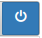
#### 2) Use plot $\Downarrow$ BELOW $\Downarrow$ to decide on trimming limits!

In [ ]:
# Print stream information and plot the z-component
print(f"Characteristis for the Z-component:\n {st[-1].stats}")

# Make a deep copy of the Z-component
trZ = st[-1].copy()

# Plot the z-component in RELATIVE TIME (nicer view)
#                            +───────+─> x-axis = 0, ...s                          
trZ.plot(color='blue', type='relative', handle=True)
#                                       +────+─> A matplotlib figure instance
trZ

#---- A safety copy for an eventual reset in the next cell ----
tr0 = trZ.copy()

---
## Data Trimming

Remove time segments of the signal.   

In [ ]:
print(f"Original trace has a duration of {trZ.stats.endtime - trZ.stats.starttime}s")
print(f"Enter a window [t[0] t[1]]s on the trace duration to trim the trace")

ent = input(f' Enter t[0] and t[1] (rtn= the whole trace):\n') or False
 
#      +───────────────────────────────────────────────+─> string lists <─+─────────────────────+
ent = ['0', str(trZ.stats.endtime - trZ.stats.starttime)] if not ent else ent.rstrip().split(' ')
# Transforms a str list into an ARRAY OF FLOATS
ent = np.array(ent, dtype=float)

#--------  TRIM trace now ==> NB: trace is modifyed in place!!!
trZ.trim(trZ.stats.starttime + ent[0], trZ.stats.starttime + ent[-1])

#Plot and print.
trZ.plot(color='red', type='relative', handle=True)
trZ

#------------------- Reset the trace from the last cell ------------------
"""
    THIS PIECE OF CODE BELOW WILL BE SUBSTITUTED WITH A CALL TO A SINPPET LATER

                tr0, trz = u.AuxReset(tr0, trz)
"""
ent = input(f' Do you want to run this cell again?(rtn= Not):\n') or False
if ent:
    trZ = tr0.copy()
    print(f' Original trace copied back.')
else:
#         +────────+─> A safety DEEP copy for an eventual reset in the next cell
    tr0 = trZ.copy()
    print(f' A safety copy was created for the next cell.')

---

## Preprocessing the data

**Preprocessing data** is done before any attempt toward any scientific analysis. The needed steps include:

- Detrend and demean the data
- Window the data
- Instrument correction   
- Low-pass filtering
- Downsample or resample the data
- Select a specific window and Pad it with zeros
- Ohter filtering stages.

### The Fourier transform

A great deal of the work is done in the frequency domain where we can analyse the signal according with its energy content by frequency, or its spectral energy contents. The **Fourier transform** is given in its integral form by
$$
F(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt \leftrightarrow f(t) =  \int_{-\infty}^{\infty} F(\omega)e^{i\omega t}dt;
$$
a Fourier pair, $f\left(t\right)\longleftrightarrow F\left(\omega\right)$. Note that the signal on the exponent is a matter of convention.

In seismics the signals are discrete in time, so we turn to the *discrete form*,
$$
F_k = \frac{1}{N} \sum_{j=0}^{N-1} f_j e^{-2\pi i k j /N} \leftrightarrow f_k = \sum_{j=0}^{N-1} F_j e^{2\pi i k j /N}
$$
where
- $j$ corresponds to a time sample $\,\rightarrow\:f_j\,\in\mathbb{R}$, is the signal at the corresponding time $j$
- $N$ is the number of time samples $\,\rightarrow\:j=1,\ldots,N$
- $k$ corresponds to a frequency value $\,\rightarrow\:F_j\,\in\mathbb{C}$, is the **amplitude** at the corresponding frequency $k$.

#### Brute force frequency content
Investigate the frequency content of the amplitude spectrum, $\in\mathbb{R}$, using *brute force*. This results in a poor spectrum with energy leakage and numerical instabilities. We need to do a better job.

In [ ]:
#----- z-component characteristics
npts = trZ.stats.npts                           # number of samples
dt   = trZ.stats.delta                          # sampling interval
fNy  = 1. / (2.0 * dt)                          # Nyquist frequency
time = trZ.times(type="relative")               # nummpy array with reative time t=0,...
lsec = time[-1]                                 # length of signal in seconds

#----- Print stream information and plot the 
print(f"z-component has {npts} at {dt}s, with a time-window {lsec}s")

# Frequency domain +───────+─> trace data as a nummpy array
FtrZ = np.fft.rfft(trZ.data)

#--------  frequency values+───────+─> length of FT of the signal
freq = np.linspace(0, fNy, len(FtrZ))

#Plot
p.pltTrSp(time, trZ.data, freq, abs(FtrZ),
        x1label='Time (s)', y1label='Amplitude',
        x2label='Frequency (Hz)', y2label='Ampl. spectrum', y2log=True
        )

---
## Demean / detrend
If the trace has a mean, $\overline{\textrm{trace}}\neq0$, or if it has a trend, most spectral enegy will leak
toward the lower frequencies $\underset{\omega\rightarrow0}{\mathcal{E}}\!\!\!\rightarrow\infty$. Have a look at the above spectrum. Deal with this by:

- Subtract a LS (least squares) from the data.
- Subtract the mean of the data

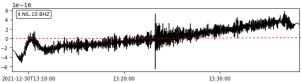

#### The code $\Downarrow$ BELOW $\Downarrow$ will change the trace *in place*;  use safety copy to run it again!

In [ ]:
#Print the data mean. Use np.float64 to assure accuracy
print(f"The mean of trace amplitudes is {np.mean(trZ.data, dtype=np.float64)}\n")
#            trace data as a nummpy array   <────+───────+

# Remove any linear trend
trZ.detrend("linear")

# Remove the mean
trZ.detrend("demean")

# Plot
#                     +──+─> x-axis in duration (s)                           
trZ.plot(color='blue', type='relative', handle=True)
#                                      +────+─> A matplotlib figure instance

#--------  Append to the processing flux in Unit03
Pflux.extend( ('linear trend', 'demean') )

#---- A safety copy for an eventual reset in the next cell ----
tr0 = trZ.copy()

## Tapering a data window
Selecting the signal by itself is equivalent to multiplying the data by a **box-car window**. The ends of the *signal* go abruptly $\rightarrow0$, causing discontinuities in the time-domain and distorting the edges in frequency-domain (Gibb's phenomenon). This would seriously affect the signal reconstructed to the time-domain, which would suffer from overshoot and ringing.
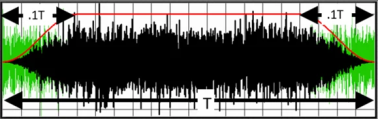

A common window is the **Hanning Window**, whichs uses a cosine function to taper both ends.

In [ ]:
trZ = tr0.copy()


ent = input(f' Enter the percentage to taper window ends (rtn=0.1)\n') or 0.1
ent = float(ent)

# Apply Hanning on the signal
trZ.taper(type = 'hann', max_percentage = ent)

#Plot
trZ.plot(color='red', type='relative', handle=True)

#--------  Append to the processing flux in Unit03
Pflux.append(('Hanning '+str(ent)))

#------------------- Reset the trace from the last cell ------------------
tr0, trZ = u.AuxReset(tr0, trZ)

## Filtering

Let $x\left(t\right)\longleftrightarrow X\left(\omega\right)$ be a Fourier pair. The application of a filter on
$x\left(t\right)$ produce yet another Fourier pair,
$$\mathcal{F}\left\{ x\left(t\right)\right\} \Rightarrow y\left(t\right)\longleftrightarrow Y\left(\omega\right)$$

The filter **frequency response function** is given by its ***transfer function*** (Fourier transform of the **output signal** divided by the Fourier transformation of the **input signal**.)

$$ T(\omega) = \frac{Y(\omega)}{X(\omega)}.$$

The transfer function of a simple lowpass filter is

$$ |T(\omega)| = \sqrt{ \frac{1}{1+(\frac{\omega}{\omega_c})^{2n}} }, $$

where:
- $\omega$ is the frequency;
- $\omega_c$ is the corner frequency;
- $n$ is the filter order, or its number of corners. It defines the slope steepness of the **transition band**, the higher it is, the steeper is the slope. 
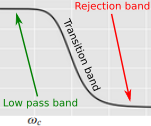

Filters can be
| **causal** |  $\Vert$ | **acausal** |
| :-: | :-: | :-: |
| Not symmetric | $\Vert$ |Symmetric |
| O/P depends on past & present of the I/P | $\Vert$ | O/P depends on past, present and future of the I/P |

- A non-causal filter without real-time future values can be achied with forward-backward filtering, where the signal is also filtered in the reverse direction in time, effectively canceling out the phase delay introduced by the forward **causal** filter.

#### Four main types of filters:
- **lowpass filter**, where the pass-band is $\omega\lessapprox\omega_{c}$
- **highpass filter**, where the pass-band is $\omega\gtrapprox\omega_{c}$
- **bandpass filter**, where the pass-band is $\omega\gtrapprox\omega_{c}\lessapprox\omega$
- **bandstop filter**, where the pass-band is $\omega\lessapprox\omega_{c}\gtrapprox\omega$

Those four filters are easily implemented in the **frequency domain**: (i) transform the signal via **FFT**; (ii) multiply it with the **FFT of the impulse response function**; and (iii) transfer the result back to the **time-domain**.

There are filters which are often implemented in the **time-domain**:
- **Infinite impulse response (IIR) filters**, which are recursive & causal, are more efficient in terms of the number of coefficients required for a sharp bandpass response but may introduce phase distortion.

- **Finite impulse response (FIR) filters**, which are non-recursive & causal or acausal, can provide a linear-phase response, which avoids phase distortion, but they may require more coefficients to achieve the same level of sharpness in the frequency response as an IIR filter.

---
### Lowpass filter the signal: Get rid of the higher frequencies

#### The sampling theorem
The main concepts in dealing with *sampled signals* are:

- The **sampling interval** is the $\delta t=t_{i=1}-t_{i},\,i=1,\ldots,N$ between any two samples, where $N$ is the **number** of samples in the signal.

- The **period**, or **time window**, or **duration** of the signal is $T = \left(N-1\right)\delta t$.

- The **sampling rate**, or **sampling frequency**, is $f_s=1/\delta t$. The **Fourier coefficients** of the transformed signal have a spacing of $\Delta f = 1/T$.

- The **sampling theorem** states that it is necessary at least **2 samples per period** to reproduce the *highest frequency of a sampled signal*, which defines the **Nyquist frequency**.
$$ f_{Ny} = \frac{1}{2\delta t} = \frac{f_s}{2}$$

- Nevertheless real data has **noise** so we need a safety margin on the **Nyquist frequency**. A safety margin of $\zeta=0.8$ or 80\% is usual. We then set the **highest frequency** as
$$ f_{max} = \zeta\frac{f_s}{2}$$

- The **demean and detrend** stage has minimized the *lower frequency* content of the data. Therefore we can set a limit for the *lower frequency* using an analogy to the **sampling theorem** approach,
$$ f_{min} = \frac{1}{2T} = \frac{\Delta f}{2}.$$

#### The relevant limits for visualization
As we have LP filtered for a corner frequency of $f_c$, there is no reason to display all frquencies up to
$\zeta f_{Ny}$ or to $f_{Ny}$, we should stop frequencies at a given $f_{c}^{\prime}>f_{c}$.
$$\underset{0}{\mid}\cdotp\!\underset{f_{min}}{\cdotp\cdotp\mid\cdotp\cdotp}\cdot\cdotp\cdotp\cdotp\underset{f_{0}}{\cdotp\cdotp\mid\cdotp}\underset{f_{0}^{\prime}}{\cdotp\mid\cdotp\cdotp}\cdot\cdotp\cdotp\cdotp\cdotp\cdotp\cdotp\underset{\zeta f_{Ny}}{\cdotp\cdotp\mid\cdotp\cdotp}\cdotp\underset{f_{Ny}}{\!\cdotp\!\mid}$$

We can estimate 
$f_{c}^{\prime}$ using the attenuation of a Butterworth filter,
$$ \mathcal{A}\left(f\right) = 10\log_{10} \left(1+\left(\frac{f_{c}^{\prime}}{f_{c}}\right)^{2n}\right), $$
where $n$ is the filter order, or its number of corners.

An attenuation of $40\textrm{dB}$ represents a drop in amplitude of $10^2$ or 1\%, or a $10^4$ drop in the energy. Therefore substituting $\mathcal{A}=40$ and $n=4$  in the above expression, we get
$$f_{c}^{\prime}=f_{c}\sqrt{10}\approx3f_{c}$$

In [ ]:
#------- Print relevant information for filtering
print(f"The trace time window is {trZ.times(type='relative')[-1]}s long with {trZ.stats.npts} samples\n")
#-- An estimate for the lowest frequency
dummy = 1. / (2.0 * trZ.times(type='relative')[-1])
print(f"The lower frequency is {np.round(dummy, 5)}Hz\n")
#
print(f"The sampling frequency is {np.round(1. / trZ.stats.delta, 5)}Hz,\n")
print(f"impying in a Nyquist frequency of {1. / (2.0 * trZ.stats.delta)}Hz\n")
#\_______________________________________________________________________________________________________________/

In [ ]:
#------- I/P of the relevant paramenters
print(f"Enter the corner frequency, filter order, zerophase and a safety margin for the Nyquist: f0, nc, zP, sfty")
print(f" if just I/P f0, then Nc = 4, zP = True, sfty = 0.8")
print(f"Suggestion: 0.5 =< f0 >= 1\n")
ent = input(f' Enter fc, nc and zP (dflt: Nc=4, zP=True, sfty = 0.8)\n')
#
ent = ent.rstrip().split(' ')

#      +─────────────────────────+─>     Python lists!   <─+─────────────────────────────────────────────────────+
ent = [float(ent[0]), 4, True, 0.8] if len(ent) == 1 else [float(ent[0]), int(ent[1]), bool(ent[2]), float(ent[3])]
#                                                  Here any entry evaluates to True  <─^──────────^

#--------  Use aliases (# from a copy!) to make life easier
fc, nc, zP, sfty = ent[:]
#\_______________________________________________________________________________________________________________/

#------- Acausal filter/zero phase if zP=True, otherwise a causal filter. Filter with sanity
if tr0 == trZ:
    trZ.filter('lowpass', freq=fc, zerophase=zP, corners=nc)
else:
    raise Exception("Trace contents has changed from previous cell")
#\_______________________________________________________________________________________________________________/

#--------  Transforms the trace data to the Frequency Domain (up to the Nyquist)
FtrZ = np.fft.rfft(trZ.data)

#-------- Limit frequency <= 3*fc and limits fft array accordingly
#           From above: fNy  = 1. / (2.0 * trZ.stats.delta) 
#                       freq = np.linspace(0, fNy, len(FtrZ))
freq, FtrZ = u.lmt_ValInd(freq, FtrZ, 3. * fc)
#              Attenuation of 40dB <─+^^^^^^^+


#-------- Plot
#           From above: time = trZ.times(type="relative")
p.pltTrSp(time, trZ.data, freq, abs(FtrZ),
        x1label='Time(s)',        y1label='Amplitude(m/s)',
        x2label='Frequency (Hz)', y2label='Ampl. spectrum', y2log=True
        )

#--------  Append to the processing flux in Unit03
Pflux.append(('lowpass '+str(fc)+'Hz'))

#------------------- Reset the trace from the last cell ------------------
tr0, trZ = u.AuxReset(tr0, trZ)

---
### Save the filtered data

_Save the filtered data data in miniSEED_ in the same directory as this Jupyter notebook. Sspecify file path, name, extension, and data format:

**stream.write('/path/filename.mseed', format='MSEED')**.

In [ ]:
#-------- Save the filtered data (wb=western-brazil, lp=low pass filtered)
filename = '../Data/wb11793085lp' + '.mseed'
dummy = input(f'>> Save filtered data '+filename+' (rtn = No): \n') or False
if dummy:
    trZ.write(filename, format='MSEED')

# Sanity
    try:
        dummy = read(filename)
        print(f"Filtered Z-data at station IU HKT:\n {dummy[-1].stats}")
    except:
        print(f".")
        print(f"Failed to write the data if file {filename}")
        
#--------  Append to the processing flux in Unit03 adnd write it to a file
Pflux.append('written '+filename)

#--- Write
with open('../Data/Pflux03.txt', 'w') as f:
    for ent in Pflux:
        f.write('%s\n' %ent)
f.close()